# Real-time inference example

This notebook will act as a template to deploy a very simple *CNN* model to AWS. It consist broadly of these steps:
1. Package the CNN model and some dependencies as a `.tar.gz` file.
2. Upload said `.tar.gz` file to the cloud.
3. Use the `sagemaker.pytorch.PyTorchModel` to initlize a `model` which will be deployed.
4. Deploy said the model with `model.deploy`, and try it out with predict

In [36]:
import sagemaker
from sagemaker.pytorch import PyTorchModel
import tarfile

In [37]:
# Define the name of the S3 bucket where the model will be stored
model_bucket = 'blankt-master-thesis-superresolution'
# Define the key (or path) to the model within the S3 bucket
model_key = 'model'

# Create an instance of the SageMaker session and get the execution role for the notebook instance
sagemaker_session = sagemaker.Session()
sagemaker_role = sagemaker.get_execution_role()
print(f'Execution roll {sagemaker_role}')

Execution roll arn:aws:iam::296862834425:role/service-role/AmazonSageMaker-ExecutionRole-20230321T182690


## Create the `.tar.gz` file

**`model.pt`**: Is the saved pytorch model, a very simple CNN trained on MNIST in our case.

**`inference.py`**: The logic of the model. Many of these functions are standardized for Sagemaker.

**`cnn.py`**: The architecture of the network, must match `model.pt`. Does not need to be included here, but can be packed in later.

The structure of the file will look like this:

```bash
./
├── model.pt
├── inference.py
└── code/
    ├── requirements.txt
    └── cnn.py
```

In [38]:
with tarfile.open('model.tar.gz', 'w:gz') as archive:
    archive.add('model_zoo/model.pt', arcname='model.pt')
    archive.add('inference.py')
    archive.add('code/requirements.txt')
    archive.close()

## Upload the model to the **S3**-bucket.

You can put the code wherever you want on the S3-bucket, just make sure you put that path when deploying the model.

In [39]:
s3_path = sagemaker_session.upload_data(
    path=f"{model_key}.tar.gz",
    bucket=model_bucket,
    key_prefix=f'{model_key}')
print("input spec (in this case, just an S3 path): {}".format(s3_path))

input spec (in this case, just an S3 path): s3://blankt-master-thesis-superresolution/model/model.tar.gz


## Deploying the model

First snippet of code is defining the condiguration of the model.

In [40]:
model = PyTorchModel(
    model_data=s3_path,  # Path to the model artifacts in Amazon S3
    role=sagemaker_role,  # IAM role used by SageMaker to access AWS resources
    entry_point='inference.py',  # Entry point script for inference
    source_dir='code',  # Directory containing the CNN model and requirement.txt file
    framework_version="1.5.0",  # Version of the PyTorch framework
    py_version='py3'  # Version of Python
    )

In [41]:
import time
from datetime import datetime, timedelta
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer
from datetime import datetime

time_stamp = datetime.now().strftime("%y-%m-%d-%H-%M-%S")  # Get the current timestamp

start_time = time.perf_counter()  # Start the timer


predictor = model.deploy(
    endpoint_name=f"cnn-realtime-inference-{time_stamp}",  # Set the name of the endpoint with a timestamp
    instance_type='ml.m4.xlarge',  # Set the instance type for deployment
    initial_instance_count=1,  # Set the initial number of instances to run the endpoint
    serializer=JSONSerializer(),  # Set the serializer for input data as JSON
    deserializer=JSONDeserializer()  # Set the deserializer for JSON responses
)

# Calculate the time elapsed for deployment
time_elapsed = time.perf_counter() - start_time  
timedelta(0, seconds=65)  
time_string = timedelta(0, seconds=time_elapsed)
time_string = time.strftime('%H:%M:%S', time.gmtime(time_string.seconds))
print(f"\nDeploying model took {str(time_string)}.")

-----!
Deploying model took 00:03:02.


## Fetch MNIST data for testing the model

In [42]:
!pip install python-mnist
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt

# Loading the MNIST dataset
mndata = MNIST('../mnist')
test_images, test_labels = mndata.load_testing()
test_images, test_labels = np.array(test_images), np.array(test_labels)

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


## Make predition with our CNN classifier

The following code snippet takes a random sample from MNIST and uses it our model `predictior`. 

Note that the classifier is only 98% correct, which means that it can be wrong sometimes, so try re-runing the below snippet a couple of times!

Predicted 8, true label was 8


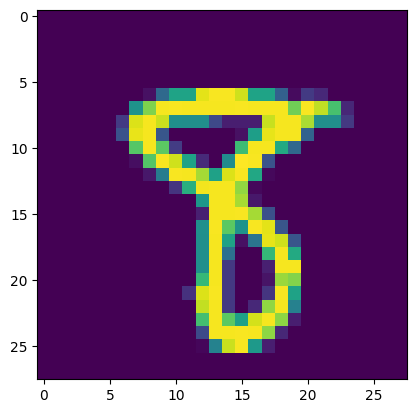

In [43]:
IMG_DIM = 28  # The dimension of the images

img_idx = np.random.randint(len(test_images))  # Generate a random index to select a test image

result_raw = predictor.predict({'inputs': test_images[img_idx].reshape(1, 1, IMG_DIM, IMG_DIM).tolist()})  # Make a prediction on the selected image
result = np.argmax(result_raw)  # Extract the predicted label from the prediction result
true_label = test_labels[img_idx]  # Get the true label for the selected image

print(f'Predicted {result}, true label was {true_label}')  # Print the predicted and true labels

plt.imshow(test_images[img_idx].reshape(IMG_DIM, IMG_DIM))  # Display the selected image
plt.show()

## Clean-up, as this notebook is only for demonstration purposes

In [44]:
try:
    predictor.delete_endpoint()
    print(f'Predictor "{predictor.endpoint_name}" deleted.')
except:
    print(f'Predictor "{predictor.endpoint_name}" does not exist.')

try:
    model.delete_model()
    print(f'Model "{model.name}" deleted.')
except:
    print(f'Model "{model.name}" does not exist.')

Predictor "cnn-realtime-inference-23-07-01-12-10-07" deleted.
Model "pytorch-inference-2023-07-01-12-10-08-551" deleted.
